In [1]:
import torch
from torch import nn

from fastphm.data.Dataset import Dataset
from fastphm.data.labeler.RulTurbofanLabeler import RulTurbofanLabeler
from fastphm.data.loader.turbofan.CMAPSSLoader import CMAPSSLoader
from fastphm.metric.Evaluator import Evaluator
from fastphm.metric.end2end.MSE import MSE
from fastphm.metric.end2end.MAE import MAE
from fastphm.metric.end2end.PHM2008Score import PHM2008Score
from fastphm.metric.end2end.PHM2012Score import PHM2012Score
from fastphm.metric.end2end.PercentError import PercentError
from fastphm.metric.end2end.RMSE import RMSE
from fastphm.model.pytorch.PytorchModel import PytorchModel
from fastphm.util.Plotter import Plotter

## 定义：提出的模型（仅供示例）

In [2]:
class ProposedModel(nn.Module):
    def __init__(self):
        super(ProposedModel, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=8, kernel_size=(1, 3), padding=(0, 1), bias=False)
        self.conv1_1 = nn.Conv2d(in_channels=1, out_channels=8, kernel_size=1, bias=False)
        self.conv2 = nn.Conv2d(in_channels=8, out_channels=16, kernel_size=(1, 3), padding=(0, 1), bias=False)
        self.conv2_1 = nn.Conv2d(in_channels=8, out_channels=16, kernel_size=1, bias=False)
        self.conv3 = nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(1, 3), padding=(0, 1), bias=False)
        self.pool = nn.AvgPool2d(kernel_size=(1, 2), stride=2)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(32, 16)
        self.fc2 = nn.Linear(16, 1)

    def forward(self, x):
        x = x.unsqueeze(1)  # 增加通道维度，x的形状(批量，通道，传感器，时间)
        shortcut1 = x
        shortcut1 = self.conv1_1(shortcut1)
        x = self.conv1(x)
        x = torch.relu(x)
        x = x + shortcut1
        x = self.pool(x)
        shortcut2 = x
        shortcut2 = self.conv2_1(shortcut2)
        x = self.conv2(x)
        x = torch.relu(x)
        x = x + shortcut2
        x = self.pool(x)
        shortcut3 = x
        x = self.conv3(x)
        x = torch.relu(x)
        x = x + shortcut3
        x = self.pool(x)
        x = self.flatten(x)
        x = self.fc1(x)
        x = torch.relu(x)
        x = self.fc2(x)
        x = 125 * torch.sigmoid(x)
        return x

## 定义：必要组件
- 数据加载器，获取原始数据
- 标签器，用于生成训练数据和测试数据
- 需要去掉的恒定特征

In [3]:
data_loader = CMAPSSLoader('D:\\data\\dataset\\CMAPSSData')
labeler_all_sample = RulTurbofanLabeler(window_size=15, window_step=1, max_rul=125)
labeler = RulTurbofanLabeler(window_size=15, window_step=1, max_rul=125, last_cycle=True)
columns_to_drop = [0, 1, 2, 3, 4, 8, 9, 13, 19, 21, 22]
feature_size = 14
Plotter.DPI = 80

DEBUG - 19:53:19 >> 
<< Root directory of dataset: D:\data\dataset\CMAPSSData
	FD001_RUL, location: D:\data\dataset\CMAPSSData\RUL_FD001.txt
	FD002_RUL, location: D:\data\dataset\CMAPSSData\RUL_FD002.txt
	FD003_RUL, location: D:\data\dataset\CMAPSSData\RUL_FD003.txt
	FD004_RUL, location: D:\data\dataset\CMAPSSData\RUL_FD004.txt
	FD001_test, location: D:\data\dataset\CMAPSSData\test_FD001.txt
	FD002_test, location: D:\data\dataset\CMAPSSData\test_FD002.txt
	FD003_test, location: D:\data\dataset\CMAPSSData\test_FD003.txt
	FD004_test, location: D:\data\dataset\CMAPSSData\test_FD004.txt
	FD001_train, location: D:\data\dataset\CMAPSSData\train_FD001.txt
	FD002_train, location: D:\data\dataset\CMAPSSData\train_FD002.txt
	FD003_train, location: D:\data\dataset\CMAPSSData\train_FD003.txt
	FD004_train, location: D:\data\dataset\CMAPSSData\train_FD004.txt


## 出图：涡扇发动机（原始数据）

INFO - 19:53:19 >> Loading data entity: FD001_train_1
INFO - 19:53:19 >> Successfully loaded data entity: FD001_train_1


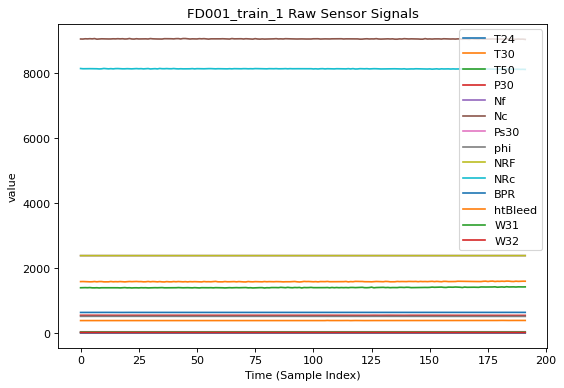

'FD001_train_1 Raw Sensor Signals'

In [4]:
turbofan = data_loader('FD001_train_1', columns_to_drop)
Plotter.raw(turbofan)

## 出图：涡扇发动机（归一化数据）

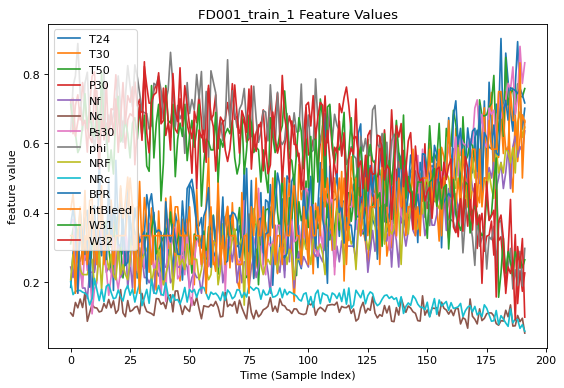

'FD001_train_1 Feature Values'

In [5]:
Plotter.feature(turbofan)

## 生成训练数据

In [6]:
turbofans_train = data_loader.batch_load('FD001_train', columns_to_drop)
train_set = Dataset()
for turbofan in turbofans_train:
    train_set.append(labeler_all_sample(turbofan))

INFO - 19:53:19 >> Loading data entity: FD001_train_1
INFO - 19:53:19 >> Successfully loaded data entity: FD001_train_1
INFO - 19:53:19 >> Loading data entity: FD001_train_2
INFO - 19:53:19 >> Successfully loaded data entity: FD001_train_2
INFO - 19:53:19 >> Loading data entity: FD001_train_3
INFO - 19:53:19 >> Successfully loaded data entity: FD001_train_3
INFO - 19:53:19 >> Loading data entity: FD001_train_4
INFO - 19:53:19 >> Successfully loaded data entity: FD001_train_4
INFO - 19:53:19 >> Loading data entity: FD001_train_5
INFO - 19:53:19 >> Successfully loaded data entity: FD001_train_5
INFO - 19:53:19 >> Loading data entity: FD001_train_6
INFO - 19:53:19 >> Successfully loaded data entity: FD001_train_6
INFO - 19:53:19 >> Loading data entity: FD001_train_7
INFO - 19:53:19 >> Successfully loaded data entity: FD001_train_7
INFO - 19:53:19 >> Loading data entity: FD001_train_8
INFO - 19:53:19 >> Successfully loaded data entity: FD001_train_8
INFO - 19:53:19 >> Loading data entity: 

## 生成测试数据

In [7]:
turbofan_test = data_loader.batch_load('FD001_test', columns_to_drop)
test_set = Dataset()
for turbofan in turbofan_test:
    test_set.append(labeler(turbofan))

INFO - 19:53:20 >> Loading data entity: FD001_test_1
INFO - 19:53:20 >> Successfully loaded data entity: FD001_test_1
INFO - 19:53:20 >> Loading data entity: FD001_test_2
INFO - 19:53:20 >> Successfully loaded data entity: FD001_test_2
INFO - 19:53:20 >> Loading data entity: FD001_test_3
INFO - 19:53:20 >> Successfully loaded data entity: FD001_test_3
INFO - 19:53:20 >> Loading data entity: FD001_test_4
INFO - 19:53:20 >> Successfully loaded data entity: FD001_test_4
INFO - 19:53:20 >> Loading data entity: FD001_test_5
INFO - 19:53:20 >> Successfully loaded data entity: FD001_test_5
INFO - 19:53:20 >> Loading data entity: FD001_test_6
INFO - 19:53:20 >> Successfully loaded data entity: FD001_test_6
INFO - 19:53:20 >> Loading data entity: FD001_test_7
INFO - 19:53:20 >> Successfully loaded data entity: FD001_test_7
INFO - 19:53:20 >> Loading data entity: FD001_test_8
INFO - 19:53:20 >> Successfully loaded data entity: FD001_test_8
INFO - 19:53:20 >> Loading data entity: FD001_test_9
INF

## 定义模型并训练

In [8]:
model = PytorchModel(ProposedModel())
model.train(train_set, epochs=120, batch_size=256, lr=0.01, weight_decay=0.01)

INFO - 19:53:20 >> 
<< Successfully initialized model:
	class: ProposedModel
	device: cuda
	dtype: torch.float32
INFO - 19:53:20 >> 
<< Start training model:
	loss function: MSELoss
	optimizer: Adam
	learning rate: 0.01
	weight decay: 0.01
	batch size: 256
DEBUG - 19:53:21 >> Epoch 1/120, Loss: 1804.4808397795
DEBUG - 19:53:21 >> Epoch 2/120, Loss: 785.5152041787
DEBUG - 19:53:21 >> Epoch 3/120, Loss: 560.6347853008
DEBUG - 19:53:21 >> Epoch 4/120, Loss: 531.3088559602
DEBUG - 19:53:21 >> Epoch 5/120, Loss: 556.3190058658
DEBUG - 19:53:22 >> Epoch 6/120, Loss: 504.0024361861
DEBUG - 19:53:22 >> Epoch 7/120, Loss: 501.8275544016
DEBUG - 19:53:22 >> Epoch 8/120, Loss: 491.2852345517
DEBUG - 19:53:22 >> Epoch 9/120, Loss: 497.0433237176
DEBUG - 19:53:22 >> Epoch 10/120, Loss: 482.7820896349
DEBUG - 19:53:22 >> Epoch 11/120, Loss: 485.4255383140
DEBUG - 19:53:23 >> Epoch 12/120, Loss: 477.7678600111
DEBUG - 19:53:23 >> Epoch 13/120, Loss: 473.4831121344
DEBUG - 19:53:23 >> Epoch 14/120, Lo

## 出图：训练过程的损失变化

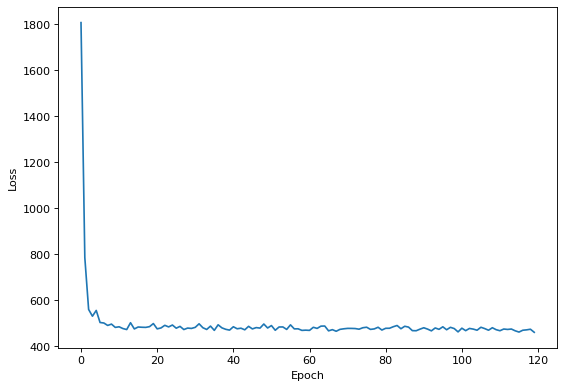

In [9]:
Plotter.loss(model)

## 做出预测

In [10]:
result = model.test(test_set)

## 预测结果评价（FD001测试集中所有的发动机）

INFO - 19:53:43 >> 
<< Performance Evaluation of FD001_test:
	MAE: 16.7978
	MSE: 516.9924
	RMSE: 22.7375
	Percent Error: -8.01%
	PHM2012 Score: 0.3510
	PHM2008 Score: 3952.2094


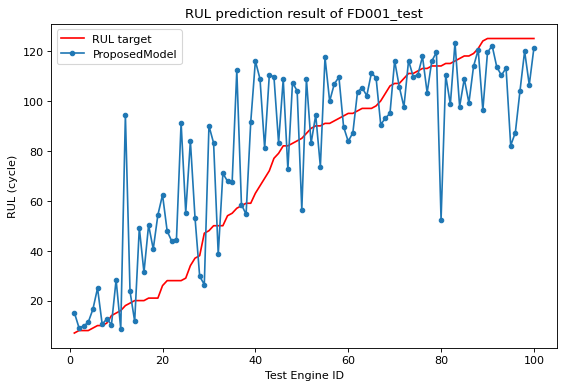

'RUL prediction result of FD001_test'

In [11]:
test_set.name = 'FD001_test'
evaluator = Evaluator()
evaluator.add(MAE(), MSE(), RMSE(), PercentError(), PHM2012Score(), PHM2008Score())
evaluator(test_set, result)
Plotter.rul_ascending(test_set, result, is_scatter=False, label_x='Test Engine ID', label_y='RUL (cycle)')

## 出图：预测结果（单个涡扇发动机的所有滑动窗口样本）

INFO - 19:53:43 >> Loading data entity: FD001_test_100
INFO - 19:53:43 >> Successfully loaded data entity: FD001_test_100


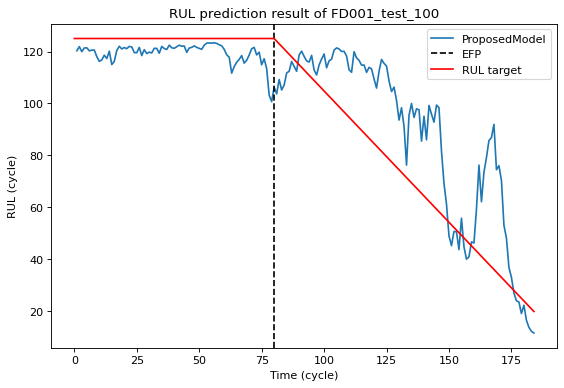

'RUL prediction result of FD001_test_100'

In [12]:
turbofan = data_loader('FD001_test_100', columns_to_drop)
a_test = labeler_all_sample(turbofan)
result_all_sample = model.test(a_test)
Plotter.rul_end2end(a_test, result_all_sample, is_scatter=False, label_x='Time (cycle)', label_y='RUL (cycle)')